In [1]:
import os

os.environ["LIBROSA_CACHE_DIR"] = "/tmp/librosa"
os.environ["LIBROSA_CACHE_LEVEL"] = "50"

In [2]:
from multiprocessing import Pool, cpu_count

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
from tensorflow import keras
from tqdm import tqdm

from lib.utils import fix_random_seed, float2d_to_rgb, read_json
from src.config import c
from src.data_utils import (
    boost_multiple_occurences,
    geofilter_predictions,
    normalize_soundscapes_df,
    predictions_to_text_labels,
    read_soundscapes_info,
)
from src.generator import Generator
from src.geo_filter import filters as geo_filters
from src.models import Div, SinCos, YMToDate
from src.services import get_msg_provider, get_wave_provider

In [3]:
N_MELS = TIME_STEPS = 256
POWER = 2
DEVICE = "cpu"
N_FFT = 2048

c["MSG_POWER_TO_DB"] = False
c["MSG_DEVICE"] = DEVICE
c["MSG_N_FFT"] = N_FFT

In [4]:
wave_p = get_wave_provider(c)
msg_p = get_msg_provider(c)

x = wave_p.get_audio_fragment("XC11209.ogg", [0, 5])

In [5]:
ipd.Audio(data=x, rate=c["AUDIO_SR"])

In [6]:
msg = msg_p.msg(x, n_mels=N_MELS, time_steps=TIME_STEPS, power=POWER)

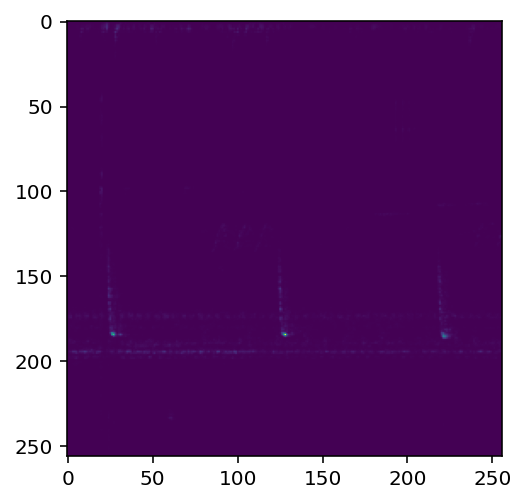

In [7]:
plt.imshow(msg)

In [8]:
class PowerToDb(keras.layers.Layer):
    """
    Does roughly the same as librosa.power_to_db() but faster.

    Takes 2D float32 input, not RGB uint8 image.
    Should be followed by Flot2dToRGB layer for input into EfficientNet.

    Use:

    ```python
    i = keras.layers.Input(shape=msg.shape, dtype='float32')
    x = PowerToDb()(i)
    m = keras.models.Model(inputs=[i], outputs=[x])
    ```

    """

    def __init__(self, ref=1.0, amin=1e-10, top_db=80, **kwargs):
        super(PowerToDb, self).__init__(**kwargs)

        if amin <= 0:
            raise Exception("amin must be strictly positive")

        if top_db is not None:
            if top_db < 0:
                raise Exception("top_db must be non-negative")

        self._ref = np.abs(ref)
        self._amin = amin
        self._top_db = top_db

    def call(self, inputs):
        # see https://github.com/librosa/librosa/blob/main/librosa/core/spectrum.py#L1447

        LOG10 = 2.302585092994046

        log_spec = K.cast(inputs, "float32")

        log_spec = (
            10.0 * K.log(K.clip(log_spec, min_value=self._amin, max_value=None)) / LOG10
        )

        log_spec -= 10.0 * K.log(K.max([self._amin, self._ref])) / LOG10

        if self._top_db is not None:

            log_spec = K.clip(
                log_spec, min_value=K.max(log_spec) - self._top_db, max_value=None
            )

        return log_spec

    def get_config(self):
        return {
            "ref": self._ref,
            "amin": self._amin,
            "top_db": self._top_db,
        }

In [10]:
i = keras.layers.Input(shape=msg.shape, dtype="float32")
x = PowerToDb(top_db=80)(i)
m = keras.models.Model(inputs=[i], outputs=[x])

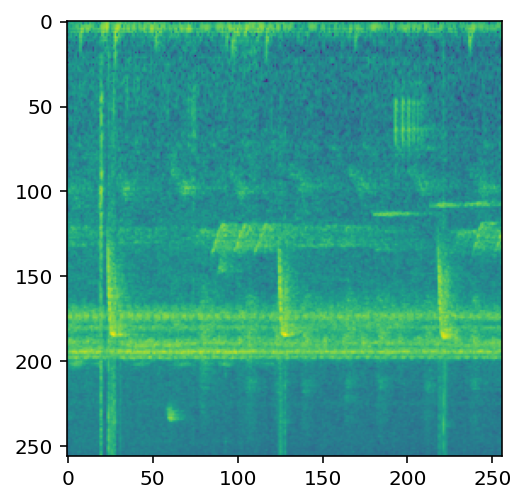

In [11]:
msg_db_my = m.predict(np.array(msg)[np.newaxis, ...])[0]
plt.imshow(msg_db_my.astype(np.float32))

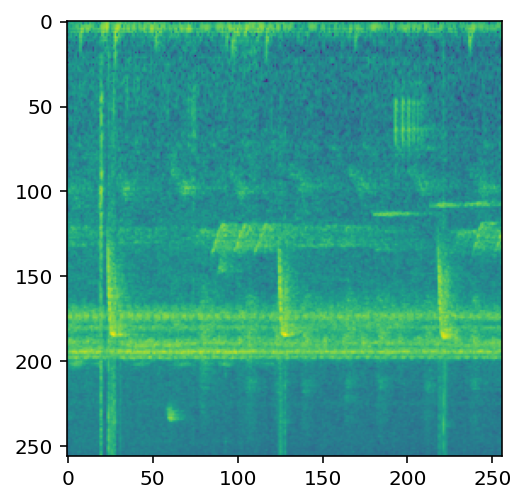

In [12]:
msg_db_lr = librosa.power_to_db(msg, top_db=80)
plt.imshow(msg_db_lr)

In [14]:
wave_p = get_wave_provider(c)
c["MSG_POWER_TO_DB"] = False
msg_p = get_msg_provider(c)


generator = Generator(
    df=pd.read_pickle("/app/_work/dataset-C.pickle"),
    shuffle=True,
    augmentation=None,
    rating_as_sw=False,
    rareness_as_sw=False,
    msg_provider=msg_p,
    wave_provider=wave_p,
    msg_output_size=(256, 256),
    msg_power=3,
    batch_size=1,
)

In [27]:
generator._shuffle_samples()

for i in tqdm(range(1000)):
    x, _, _ = generator.__getitem__(i)
    msg_db_my = m.predict(x["i_msg"])[0]
    msg_db_lr = librosa.power_to_db(x["i_msg"][0], top_db=80)
    assert abs(msg_db_lr.mean() - msg_db_my.mean()) < 2.1e-5
    assert abs(msg_db_lr.std() - msg_db_my.std()) < 2e-5

100%|██████████| 1000/1000 [00:53<00:00, 18.85it/s]


In [26]:
abs(msg_db_lr.mean() - msg_db_my.mean()), abs(msg_db_lr.std() - msg_db_my.std())

(2.0980835e-05, 2.3841858e-06)

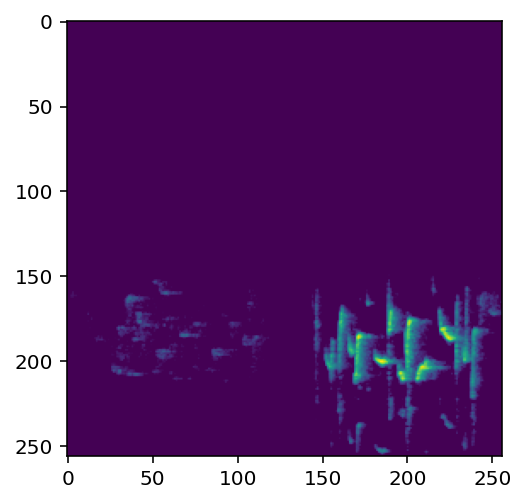

In [24]:
plt.imshow(msg_db_my)

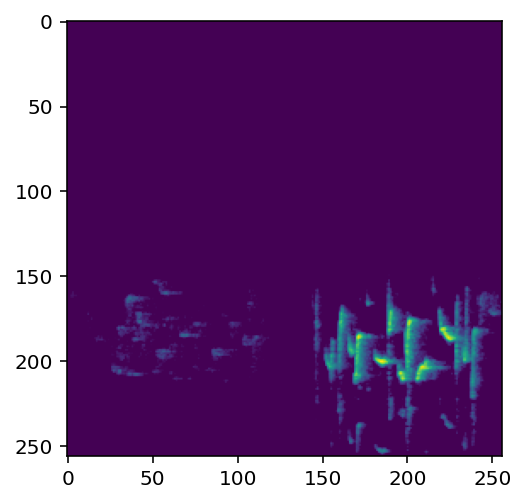

In [25]:
plt.imshow(msg_db_lr)

In [ ]:
# x, _, _ = generator.__getitem__(i)
# x['i_msg'] = x['i_msg'].astype(np.float64)

# for i in tqdm(range(100)):
#     msg_db_my = m.predict(x['i_msg'])[0]
# #     msg_db_lr = librosa.power_to_db(x['i_msg'][0], top_db=80)
# #     assert (msg_db_lr - msg_db_my).mean() < 2e-5

In [31]:
K.abs(-19)

<tf.Tensor: shape=(), dtype=int32, numpy=19>